# Learning `scan` with `jax` and `numpyro`

Learning `scan` - it's in the LGT time series example and it looks really powerful.

In the context of time series models, `scan` is helpful because it allows us to iterate over sequences (without a cumbersome `for` loop) while maintaining state across each iteration. 

## `scan` components:

1. **Input Function `f(carry, x)`**: `scan` takes an input function $f$ that defines the computation you want to perform at each step. This function typically takes two arguments:
   1. `carry`: A tuple that represents the state or context at the current time step. This is passed from one iteration to the next, allowing you to maintain and update state across time steps.
   2. `x`: The current element from the input sequence or array.
2. **Initial State `init`**: You also provide an initial state or `carry`` value. This is the state that the computation starts with at the first time step.
3. **Array sequence `xs`**: An iterable or sequence that you want to iterate over

Then `scan` will do the following:
* **Sequencing**: The `scan` function applies the provided function to each element in the input sequence in order, passing the current carry value and the current element x to the function. It iterates over the entire sequence.
* **Aggregation**: The output of the function at each time step can be used to produce an output sequence, and the final `carry` value at the last time step can represent the final state. The resulting sequences or values can be collected and returned.

The Input function also returns two items:

1. The carried over value(s), aka the latest state
2. An array, where each element is something returned from the Input Function `f` as it passes each element in `xs`



In [163]:
from jax import random
import jax.numpy as jnp

## Trival Example 1 - Cumulative Sum

* [From The Differential Programming Tutorial - Loopy Carry, by Eric Ma](https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html)

We'll start with the cumsum example from [From The Differential Programming Tutorial - Loopy Carry, by Eric Ma](https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html). We can implement a cumsum with a `for` loop like:

In [175]:
# xs
xs = jnp.array([1, 2, 3, 5, 7, 11, 13, 17])

result = []
cumsum = 0
for el in xs:
    cumsum += el
    result.append(cumsum)
jnp.array(result)

Array([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32)

This is identical to the cumulative sum:

In [177]:
jnp.cumsum(xs)

Array([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32)

Now, instead of a for loop, we rewrite it using lax.scan:

In [180]:
from jax import lax

def cumsum(cumsum, el):
    """
    Parameters
    ----------
    res : tuple
        A tuple - the result from the previous loop, aka the 'carry'
    el
        The current array element, also `x`
    """
    cumsum += el
    return cumsum, cumsum # ('carryover', 'accumulated')

init_sum = 0
final, result = lax.scan(cumsum, init_sum, xs)
print(final)
print(result)

59
[ 1  3  6 11 18 29 42 59]


we see that `lax.scan` returned two things: 
* The first item is the latest value of `res`
* The second item being returned is an array where each iteration appended the latest value of `res` to the end.

## Trivial Example 2: A little more of the carry function

The first two parameters in the input function can have arbitrary names but their order matters. The first item is the 'carried over value' and the second item is the current element in the `xs` input array.

Similarly the input function must have two outputs. The first output becomes the new 'carried over value' that will feed back into the input function, while the second output gets appended to an output `jax` array.

Let's have a concrete example in which we calculate compounded interest for a $100 investment with a 4% interest rate:

In [167]:
# Define a function to apply at each time step
def interest_growth(value, x):
    value = value * 1.04
    return value, value # ('carried over value', 'accumulated array')

# Define the initial state and input sequence
init_state = 100.0
T = jnp.array([1, 2, 3, 4, 5])

# Apply the scan function
# scan(f, init, xs, length=None, reverse=False, history=1)
final_state, results = lax.scan(f=interest_growth, init=init_state, xs=T)

print(final_state)
print(results)

121.66527
[104.       108.159996 112.48639  116.98584  121.66527 ]


## Trivial Example 3: `scan` in Numpyro to sample from a distribution

And what I'm really interested in is learning `scan` in the context of doing time series in `numpyro`. `numpyro` has it's own (experimental) implementation of `scan` which allows us to iteratively sample from `numpyro` primitives like `numpyro.distributions`. 

Here's a simple example of a random walk:

$$
y_{t+1} = y_t + \epsilon, \quad \epsilon \sim \mathcal{N}(0,1)
$$

To do this within a `scan` we'll also need to introduce an effect handler to deal with one of t

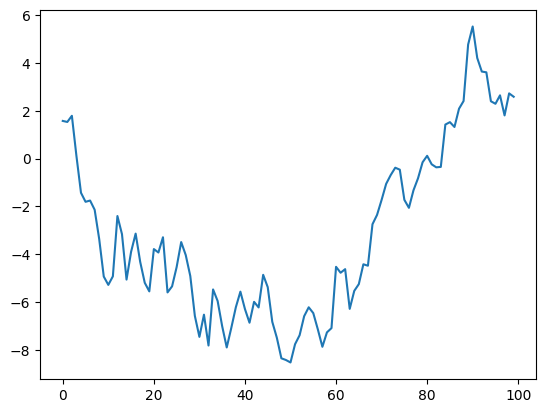

In [184]:
import numpyro
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist
import matplotlib.pyplot as plt

def random_walk(value, x):
    # Being really explicit here
    value = value + numpyro.sample('x', dist.Normal(0, 1.))
    return value, value

init_0 = 0
n_steps = 100
T = jnp.arange(n_steps)

# Need the `seed` effect handler in a context manager because of
# the need for a PRNG key within `numpyro.sample`
with numpyro.handlers.seed(rng_seed=42):
    final_location, locations = scan(random_walk, init=init_0, xs=T)

plt.plot(T, locations);

Note the addition of `numpyro.handlers.seed`. This is required due to how `numpyro` requires an explicit PRNG key when you `sample` from a distribution, so this `seed` effect handler will automatically do the `split`s on the key within each loop of the `scan` function. 

Otherwise, if you set up an explicit key with `scan` this is what you'd get:

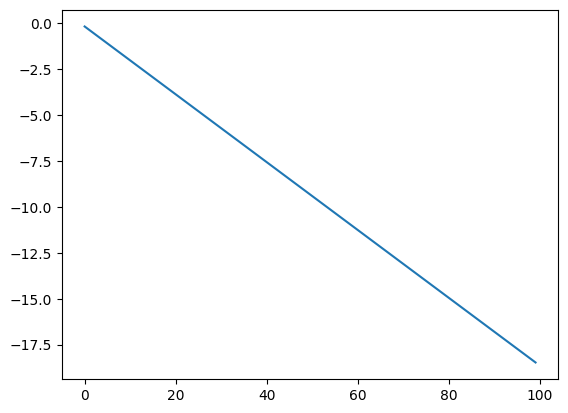

In [174]:
prng_key = random.PRNGKey(42)

def random_walk_nokey(value, x):
    # Being really explicit here
    value = value + numpyro.sample('x', dist.Normal(0, 1.), rng_key=prng_key)
    return value, value

init_0 = 0
n_steps = 100

state, final_result = scan(random_walk_nokey, init=init_0, xs=jnp.arange(n_steps))

plt.plot(jnp.arange(n_steps), final_result);

# Time Series Forecasting

## AR(2) Example

* [Example: AR2 process (numpyro docus)](https://num.pyro.ai/en/stable/examples/ar2.html#sphx-glr-download-examples-ar2-py)

Below I'll follow and document the AR2 example from the numpyro docs.

Given a univariate sequence of data:

$$
y_0, y_1, \dots, y_T
$$

We seek parameters $c$, $\alpha_1$, and $\alpha_2$ such that for each $t$ between $2$ and $T$, we have:

$$
y_t = c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2)
$$


We can restate this as:

$$
\begin{aligned}
y_t &\sim \mathcal{N}(\mu_t, \sigma)\\
\mu_t &= c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2}\\
c, \alpha_1, \alpha_2 &\sim \mathcal{N}(0,1)\\
\sigma &\sim \text{HalfNormal}(1)\\
\end{aligned}
$$

In [185]:
import numpyro 
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt
import arviz as az

def ar2_scan(y):
    """
    Bayesian autoregressive (AR) model of order 2
    """
    alpha_1 = numpyro.sample("alpha_1", dist.Normal(0, 1))  # lag 1 AR coef
    alpha_2 = numpyro.sample("alpha_2", dist.Normal(0, 1))  # lag 2 AR coef
    const = numpyro.sample("const", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))

    def transition(carry, _):
        y_prev, y_prev_prev = carry
        m_t = const + alpha_1 * y_prev + alpha_2 * y_prev_prev
        y_t = numpyro.sample("y", dist.Normal(m_t, sigma))
        carry = (y_t, y_prev)
        return carry, None

    timesteps = jnp.arange(y.shape[0] - 2)  # input into xs param in scan()
    init = (y[1], y[0])

    with numpyro.handlers.condition(data={"y": y[2:]}):
        scan(f=transition, init=init, xs=timesteps)

Note that we added another effect handler `condition` which, in this case, is conditioning $y_t$ on observed values $y$, excluding the first two values (because it's an AR(2) model).

Next we'll test this model on simulated data

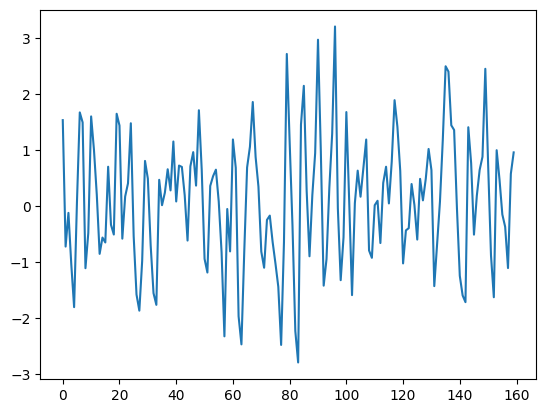

In [201]:
# constants
num_data = 160
rng_key = random.PRNGKey(42)
# Sim Data
from statsmodels.tsa.arima_process import ArmaProcess

t = jnp.arange(0, num_data)

# Generate an AR(2) model with true alpha_1=0.5, alpha_2=-0.4 and a constant.
# Statsmodels `ArmaProcess` requires that we flip the signs in the input:
ar_coef = jnp.array([1, -0.5, 0.4])
ma_coef = jnp.array([1])
arproc = ArmaProcess(ar_coef, ma_coef)

# Generate the data and convert to a jax array
y = arproc.generate_sample(num_data)
y = jnp.array(y)

# look at the data real quick:
plt.plot(t, y);

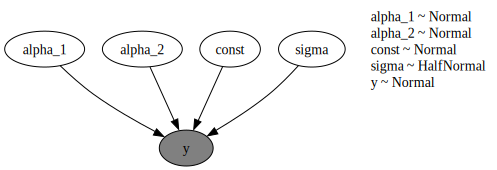

In [191]:
# Render the model so far
numpyro.render_model(ar2_scan, model_args=(y,), render_distributions=True)

In [192]:
# Inference
sampler = NUTS(ar2_scan)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=1)
mcmc.run(rng_key, y=y)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1447.21it/s, 7 steps of size 6.46e-01. acc. prob=0.92]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_1      0.46      0.07      0.46      0.35      0.57   1031.26      1.00
   alpha_2     -0.40      0.07     -0.40     -0.51     -0.28   1026.17      1.00
     const     -0.17      0.09     -0.17     -0.31     -0.04    943.96      1.00
     sigma      1.06      0.06      1.06      0.96      1.15    987.83      1.00

Number of divergences: 0


Happily, we see that the model did a pretty good job at estimating the coefficients. 

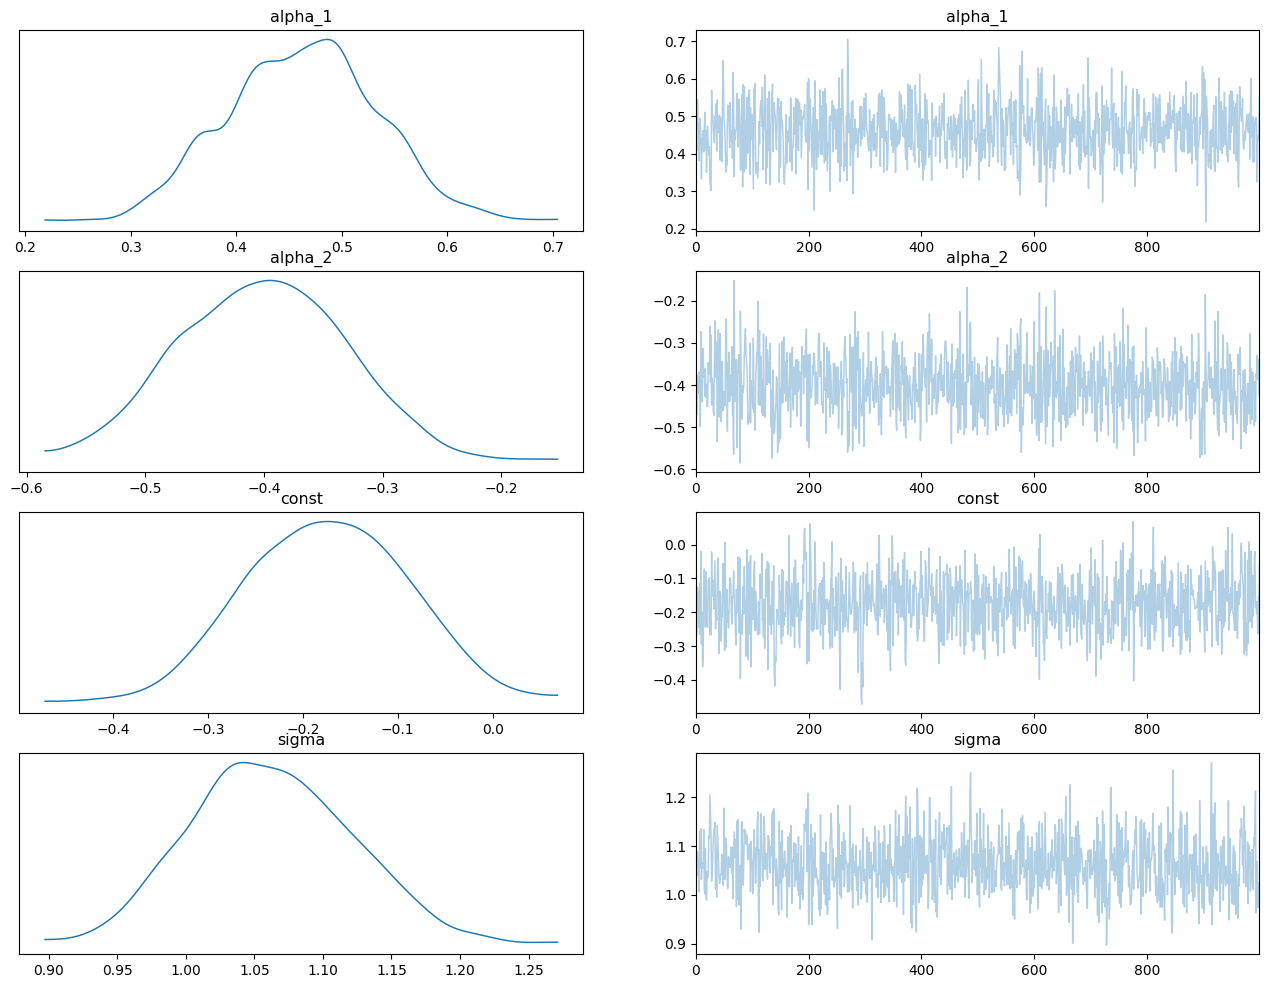

In [193]:
# Get data out as an xarray using arviz .from_numpyro() method
data = az.from_numpyro(mcmc)
# useful plot
az.plot_trace(data, compact=True, figsize=(16,12));

## AR(2) Statsmodels 


Compare the bayesian model against the statsmodels implementation

In [194]:
from statsmodels.tsa.ar_model import AutoReg

In [195]:
import numpy as np
mod = AutoReg(np.array(y), 2, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  160
Model:                     AutoReg(2)   Log Likelihood                -231.707
Method:               Conditional MLE   S.D. of innovations              1.049
Date:                Mon, 23 Oct 2023   AIC                            471.413
Time:                        16:11:17   BIC                            483.664
Sample:                             2   HQIC                           476.388
                                  160                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1740      0.085     -2.047      0.041      -0.341      -0.007
y.L1           0.4641      0.072      6.417      0.000       0.322       0.606
y.L2          -0.4051      0.072     -5.606      0.0

## Local Level model

Essentially a random walk, or a regression model in which the intercept changes over time

$$
\begin{aligned}
y_t &= \mu_t + \epsilon_t, & \epsilon_t \sim N(0, \sigma_\epsilon^2)\\ 
\mu_{t+1} &= \mu_t + \xi_t, & \xi_t \sim N(0, \sigma_\xi^2)
\end{aligned}
$$

In [100]:
def local_level(y):
    T = len(y)

    # State space model parameters
    sigma_level = numpyro.sample("sigma_level", dist.HalfCauchy(1.0))
    sigma_obs = numpyro.sample("sigma_obs", dist.HalfCauchy(1.0))
    # level_0 = numpyro.sample("level_0", dist.Normal(y[0], 1.0))
    level_0 = y[0]

    def transition_fn(carry, t):
        level_t = carry
        # State Transition
        level_t = numpyro.sample(f"level", dist.Normal(level_t, sigma_level))
        # Observation equation
        y_t = numpyro.sample("y", dist.Normal(level_t, sigma_obs))
        
        return level_t, None

    N = y.shape[0]
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, init=level_0, xs=jnp.arange(1, N)
        )

Here we use the `condition` handler so that we only `scan` over all the values of `y` except for the first one, because we're using a local level model.

## render model

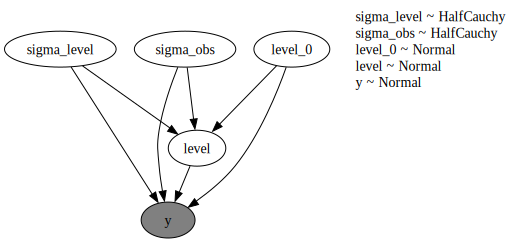

In [101]:
numpyro.render_model(local_level, model_args=(y,), render_distributions=True)

In [102]:
# sim data with numpy
np.random.seed(69)

T = 100
current_level = 0
result = []
for t in range(T):
    current_level += np.random.normal()
    result.append(current_level)

In [103]:
# sim data with jax

rng_key_ = random.PRNGKey(0)

# make an array of errors, and then we'll iterate over them
errors = dist.Normal().sample(rng_key_, (T,))

def simulate_local_level(current_level, x):
    current_level = current_level + x
    return current_level, current_level

final_state, y = scan(simulate_local_level, init=0, xs=errors)

In [104]:
## Prior Predictive
num_samples = 50
prior_predictive = Predictive(local_level, num_samples=num_samples)
prior_predictions = prior_predictive(rng_key, y)['y']

Plotting the prior predictions gets us nowhere because we conditioned on the observed values of `y`:

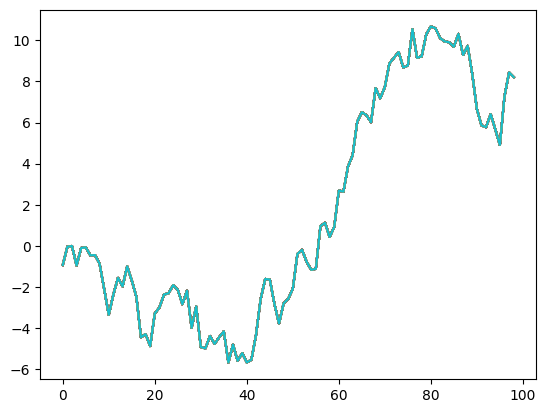

In [105]:
x = range(T-1)
for i in range(num_samples):
    plt.plot(x, prior_predictions[i])

In [106]:
# Inference
kernel = NUTS(local_level)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000)
mcmc.run(rng_key, y)

mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1285.24it/s, 3 steps of size 1.07e-01. acc. prob=0.64] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     level[0]     -0.93      0.11     -0.93     -1.07     -0.76   1543.69      1.00
     level[1]     -0.05      0.10     -0.04     -0.21      0.10    804.70      1.00
     level[2]     -0.02      0.10     -0.01     -0.17      0.10    886.85      1.01
     level[3]     -0.93      0.11     -0.95     -1.06     -0.76     81.11      1.03
     level[4]     -0.11      0.10     -0.11     -0.26      0.03   1369.79      1.00
     level[5]     -0.08      0.10     -0.07     -0.22      0.08    736.37      1.00
     level[6]     -0.46      0.10     -0.46     -0.59     -0.30   1459.89      1.00
     level[7]     -0.45      0.10     -0.45     -0.63     -0.30   1266.59      1.00
     level[8]     -0.88      0.10     -0.87     -1.02     -0.71    958.89      1.00
     level[9]     -2.10      0.09     -2.10     -2.24     -1.96   2609.22      1.00
    level[10]     -3.33      0.12     -3.35     -3.48     -3.19    134.62  

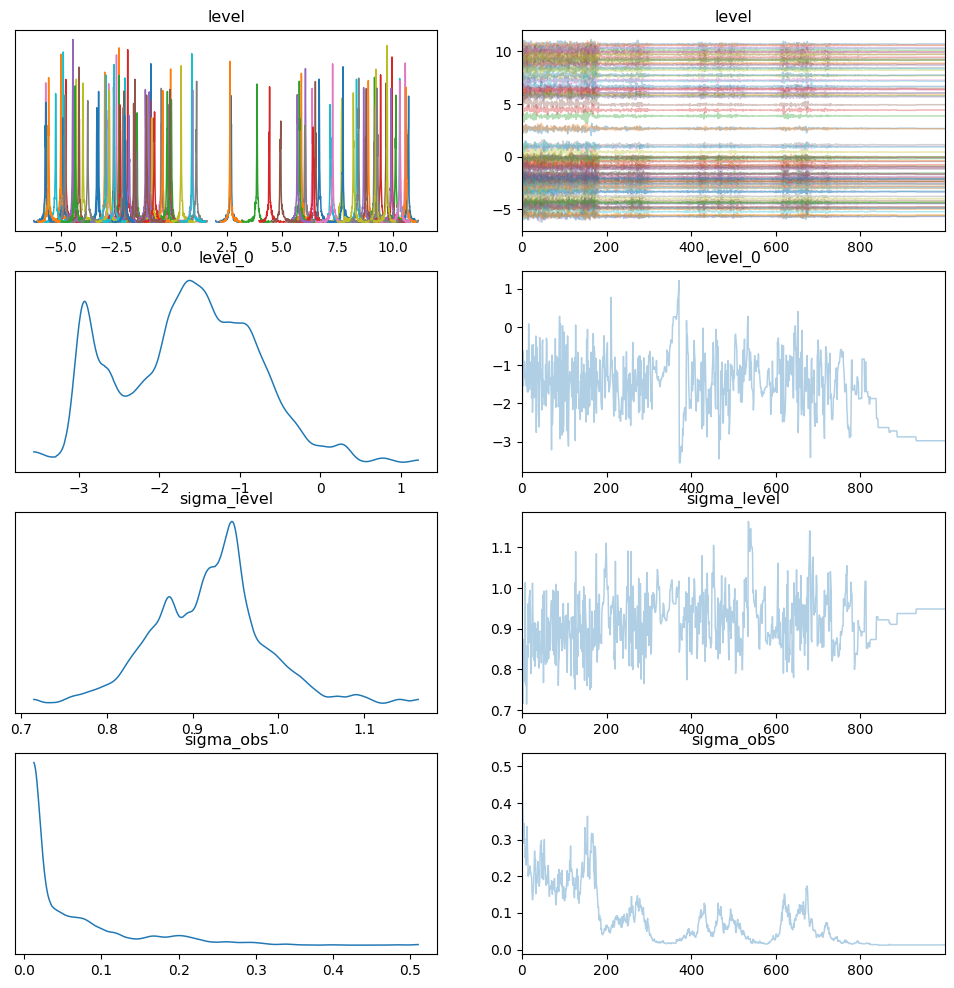

In [107]:
# useful plot
az.plot_trace(mcmc, compact=True, figsize=(12,12));

In [108]:
# Get posterior samples
samples = mcmc.get_samples()

# Extract posterior means of parameters and states
posterior_mean_level = jnp.mean(samples["level"], axis=0)
posterior_mean_sigma_level = jnp.mean(samples["sigma_level"])

print("Posterior Mean Level:", posterior_mean_level)
print("Posterior Mean Sigma Level:", posterior_mean_sigma_level)

Posterior Mean Level: [-0.9284372  -0.05156077 -0.01736136 -0.9291194  -0.11308829 -0.0801532
 -0.4556807  -0.45451024 -0.87702525 -2.1038957  -3.3310077  -2.371191
 -1.5746269  -1.9557511  -1.0206591  -1.6952916  -2.496206   -4.4236608
 -4.3053184  -4.8514037  -3.3066423  -3.0017405  -2.3734157  -2.303111
 -1.9241118  -2.1455464  -2.8228664  -2.2147405  -3.9576976  -2.9883237
 -4.898793   -4.983249   -4.393239   -4.7641306  -4.4528723  -4.1913733
 -5.648124   -4.818588   -5.580638   -5.228839   -5.665227   -5.5285273
 -4.333029   -2.6141846  -1.629552   -1.6580168  -2.8197734  -3.7512467
 -2.8112476  -2.5776913  -2.0746324  -0.41522726 -0.20813923 -0.7726501
 -1.1623902  -1.0896243   0.9380727   1.111054    0.44541493  0.93385816
  2.668141    2.6560442   3.854796    4.4260907   6.0264726   6.493685
  6.3569093   6.045655    7.6531653   7.189751    7.743284    8.874534
  9.157191    9.4219      8.693429    8.797192   10.507107    9.175288
  9.231572   10.291898   10.674247   10.580175

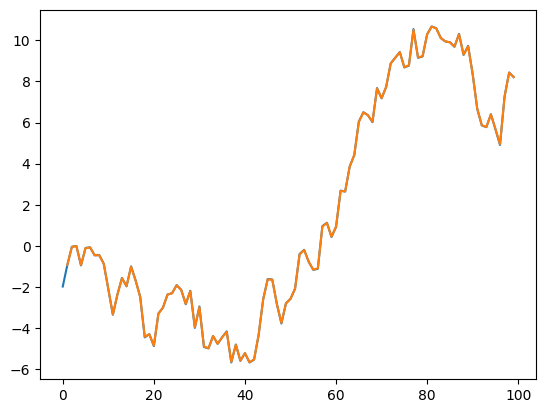

In [109]:
plt.plot(np.arange(0,T), y)
plt.plot(np.arange(1,T), posterior_mean_level)

## Local Level Nile Model

In [65]:
import statsmodels.api as sm
import pandas as pd

# This dataset is available in Statsmodels
nile = sm.datasets.nile.load_pandas().data['volume']
nile.index = pd.date_range('1871', '1970', freq='AS')

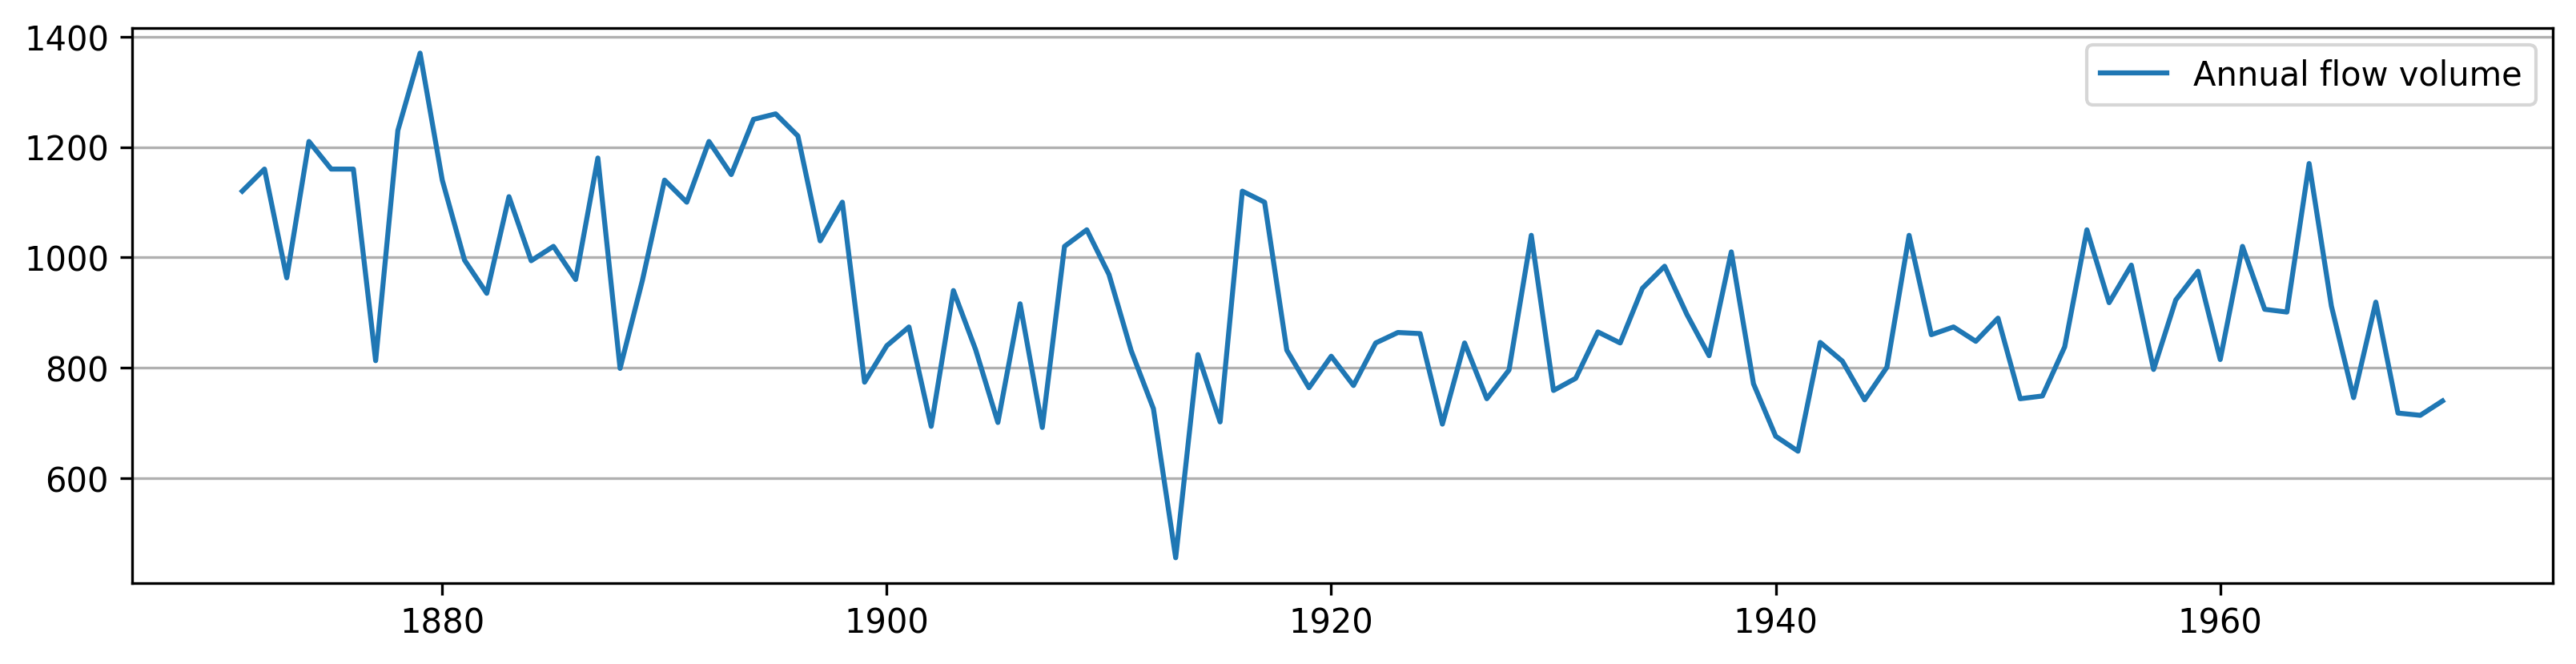

In [66]:
# Plot the series to see what it looks like
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
ax.plot(nile.index, nile, label='Annual flow volume')
ax.legend()
ax.yaxis.grid()

In [72]:
jnp.array(nile)

Array([1120., 1160.,  963., 1210., 1160., 1160.,  813., 1230., 1370.,
       1140.,  995.,  935., 1110.,  994., 1020.,  960., 1180.,  799.,
        958., 1140., 1100., 1210., 1150., 1250., 1260., 1220., 1030.,
       1100.,  774.,  840.,  874.,  694.,  940.,  833.,  701.,  916.,
        692., 1020., 1050.,  969.,  831.,  726.,  456.,  824.,  702.,
       1120., 1100.,  832.,  764.,  821.,  768.,  845.,  864.,  862.,
        698.,  845.,  744.,  796., 1040.,  759.,  781.,  865.,  845.,
        944.,  984.,  897.,  822., 1010.,  771.,  676.,  649.,  846.,
        812.,  742.,  801., 1040.,  860.,  874.,  848.,  890.,  744.,
        749.,  838., 1050.,  918.,  986.,  797.,  923.,  975.,  815.,
       1020.,  906.,  901., 1170.,  912.,  746.,  919.,  718.,  714.,
        740.], dtype=float32)

In [74]:
# Inference
kernel = NUTS(local_level)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000)
mcmc.run(rng_key, jnp.array(nile))

mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1199.25it/s, 63 steps of size 1.50e-01. acc. prob=0.84]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     level[0]   1119.59     28.93   1119.29   1073.38   1166.53    836.76      1.00
     level[1]   1116.28     37.16   1115.93   1061.59   1181.13    831.54      1.00
     level[2]   1108.96     40.07   1110.61   1042.38   1170.76    767.19      1.00
     level[3]   1114.30     42.52   1112.37   1039.15   1177.52    764.27      1.00
     level[4]   1111.90     44.40   1110.09   1045.10   1190.49    610.94      1.00
     level[5]   1104.00     42.62   1104.81   1029.66   1167.99    749.06      1.00
     level[6]   1093.20     43.29   1093.75   1024.96   1166.80    472.49      1.00
     level[7]   1108.15     43.55   1106.70   1042.02   1182.56    391.09      1.00
     level[8]   1111.99     46.58   1108.10   1046.96   1195.39    173.19      1.00
     level[9]   1094.24     42.32   1091.50   1029.07   1163.43    716.80      1.00
    level[10]   1073.66     42.88   1075.37   1003.93   1146.23    667.45  

In [75]:
# Get posterior samples
samples = mcmc.get_samples()

# Extract posterior means of parameters and states
posterior_mean_level = jnp.mean(samples["level"], axis=0)
posterior_mean_sigma_level = jnp.mean(samples["sigma_level"])

print("Posterior Mean Level:", posterior_mean_level)
print("Posterior Mean Sigma Level:", posterior_mean_sigma_level)

Posterior Mean Level: [1119.5916  1116.2802  1108.958   1114.3022  1111.8977  1103.9993
 1093.2021  1108.1542  1111.989   1094.2397  1073.6561  1062.0145
 1059.8993  1052.3895  1045.6893  1042.1848  1045.5146  1035.4557
 1045.144   1061.6041  1072.072   1083.0795  1086.7546  1089.6833
 1080.0898  1058.3483  1025.3002   993.6833   953.6751   927.6283
  907.7023   888.18726  884.9905   873.9684   863.988    867.78
  864.97736  879.27136  880.3948   867.9844   847.8305   827.1435
  812.3226   827.3808   841.75525  867.3251   870.1256   855.5516
  843.72534  838.4767   834.81055  836.25165  835.4362   831.3962
  825.0891   829.43036  830.81134  836.7751   847.7011   843.34717
  844.48114  852.65643  859.5604   865.9902   868.632    862.7427
  852.9682   847.2003   826.624    813.9817   809.2457   817.5929
  822.6739   828.716    841.0063   857.79443  858.1187   859.1697
  859.2977   858.588    855.6924   860.9299   873.2885   890.07263
  895.1789   898.98157  895.0398   900.11646  903.8124

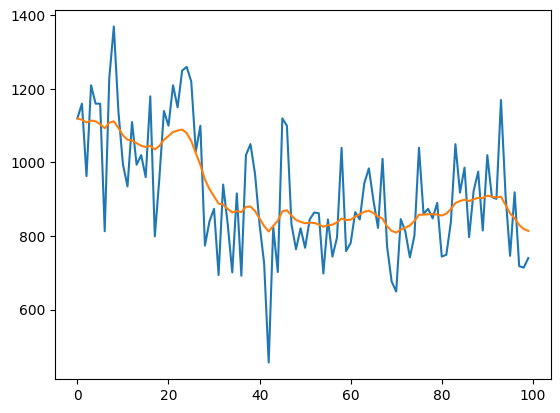

In [79]:
plt.plot(range(100), nile.values)
plt.plot(range(100), posterior_mean_level)

## Simple Exponential Smoothing

Adapted from https://num.pyro.ai/en/stable/examples/holt_winters.html

SES is:

$$
\begin{aligned}
y_t &\sim \mathcal{N}(\ell_t, \sigma_t)\\
\ell_t &= \alpha y_t + (1- \alpha)\ell_{t-1}
\end{aligned}
$$

Unlike the previous functions, there is a new `future` argument so that we can do some forecasts.

In [273]:
def ses(y, future=0):
    T = y.shape[0]
    alpha = numpyro.sample("alpha", dist.Beta(1, 1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))

    def transition_fn(carry, t):
        previous_level = carry
        level = jnp.where(
            t < T,
            alpha * (y[t]) + (1 - alpha) * (previous_level),
            previous_level,
        )
        mu = numpyro.deterministic('mu', previous_level)
        pred = numpyro.sample("pred", dist.Normal(mu, sigma))
        return level, pred

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(transition_fn, init=level_init, xs=jnp.arange(T + future))

    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

In [274]:
# Inference
kernel = NUTS(ses)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000)
mcmc.run(rng_key, jnp.array(nile))

mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1540.67it/s, 7 steps of size 7.95e-01. acc. prob=0.92]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha      0.67      0.02      0.67      0.63      0.70    803.27      1.00
  level_init      0.69      1.10      0.74     -1.24      2.37   1110.63      1.00
       sigma     43.19      0.50     43.22     42.44     44.09   1026.32      1.00

Number of divergences: 0


In [275]:
# Get posterior samples
samples = mcmc.get_samples()

In [278]:
from numpyro.diagnostics import hpdi

predictive = Predictive(ses, samples, return_sites=["y_forecast", 'pred', 'mu'])
preds = predictive(rng_key, y=y, future=10)
mean_preds = preds['pred'].mean(axis=0)
hpdi_preds = hpdi(preds['pred'])

mean_fcst = preds['y_forecast'].mean(axis=0)
hpdi_fcst = hpdi(preds['y_forecast'])

Just like before we don't get past 1-step ahead predictions but we do get the final forecast:

In [281]:
mean_mu = preds['mu'].mean(axis=0)
hpdi_mu = hpdi(preds['mu'])

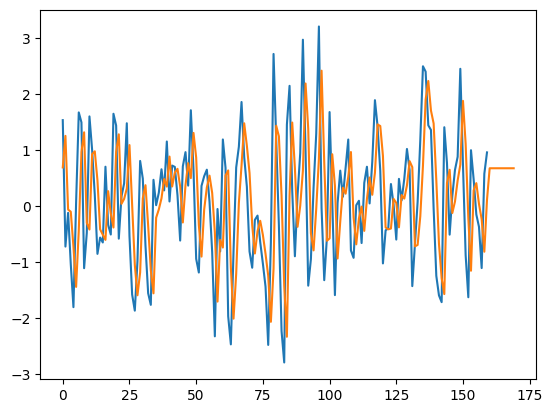

In [283]:
plt.plot(range(len(y)), y)
plt.plot(range(len(mean_mu)), mean_mu)

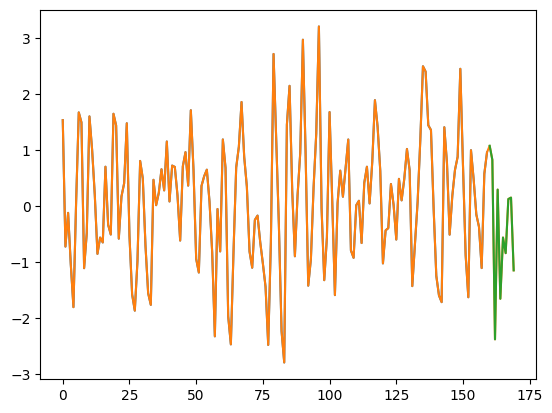

In [282]:
plt.plot(range(len(y)), y)
plt.plot(range(len(mean_preds)), mean_preds)
plt.plot(range(len(mean_preds))[-len(mean_fcst):], mean_fcst)

So I'll need to read a little more to figure out how to make this more worthwhile. So far this Bayesian model is useful to infer the hidden smoothing parameter $\alpha$ and noise $\sigma$ and to product a rudimentary forecast, but we'd need to add some extra bells and whistles so we can:

1. Evaluate the performance of this model using a 1-step ahead forecast on the past
2. Figure out how to do some of this stuff faster?
3. Take all the posterior possibilities of $\alpha$ and test how well that would have performed?

In [271]:
res = np.zeros(len(y))
alpha = 0.67
for i in np.arange(1, len(y)-1):
    res[i] = (alpha * y[i] + (1-alpha) * res[i-1])

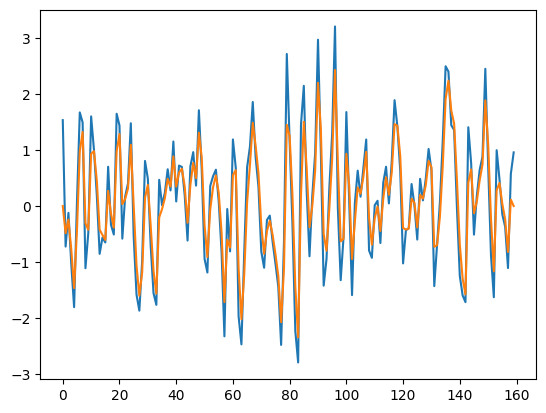

In [272]:
plt.plot(range(len(y)), y)
plt.plot(range(len(y)), res)

## Holt Winters


In [202]:
def holt_winters(y, n_seasons, future=0):
    T = y.shape[0]
    level_smoothing = numpyro.sample("level_smoothing", dist.Beta(1, 1))
    trend_smoothing = numpyro.sample("trend_smoothing", dist.Beta(1, 1))
    seasonality_smoothing = numpyro.sample("seasonality_smoothing", dist.Beta(1, 1))
    adj_seasonality_smoothing = seasonality_smoothing * (1 - level_smoothing)
    noise = numpyro.sample("noise", dist.HalfNormal(1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))
    trend_init = numpyro.sample("trend_init", dist.Normal(0, 1))
    with numpyro.plate("n_seasons", n_seasons):
        seasonality_init = numpyro.sample("seasonality_init", dist.Normal(0, 1))

    def transition_fn(carry, t):
        previous_level, previous_trend, previous_seasonality = carry
        level = jnp.where(
            t < T,
            level_smoothing * (y[t] - previous_seasonality[0])
            + (1 - level_smoothing) * (previous_level + previous_trend),
            previous_level,
        )
        trend = jnp.where(
            t < T,
            trend_smoothing * (level - previous_level)
            + (1 - trend_smoothing) * previous_trend,
            previous_trend,
        )
        new_season = jnp.where(
            t < T,
            adj_seasonality_smoothing * (y[t] - (previous_level + previous_trend))
            + (1 - adj_seasonality_smoothing) * previous_seasonality[0],
            previous_seasonality[0],
        )
        step = jnp.where(t < T, 1, t - T + 1)
        mu = previous_level + step * previous_trend + previous_seasonality[0]
        pred = numpyro.sample("pred", dist.Normal(mu, noise))

        seasonality = jnp.concatenate(
            [previous_seasonality[1:], new_season[None]], axis=0
        )
        return (level, trend, seasonality), pred

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            (level_init, trend_init, seasonality_init),
            jnp.arange(T + future),
        )

    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

# Regression with Time Varying Coefficients

Similar to the local level, we can do a dynamic regression with time varying coefficients. A simple way to model time varying coefficients is to model the evolution as a random walk:

$$
\begin{aligned}
y_t &= x_t\beta_t + \epsilon_t, & \epsilon_t \sim N(0, \sigma_\epsilon^2)\\ 
\beta_{t+1} &= \beta_t + \xi_t, & \xi_t \sim N(0, \sigma_\xi^2)
\end{aligned}
$$

where $x_t$ is a $1 \times k$ vector of data and $\beta_t$ is a $k \times 1$ vector of coefficients at time $t$.

### Note: WIP (doesn't work)

In [ ]:
def dynamic_regression(y, X):
    T = len(y)

    # State space model parameters
    sigma_level = numpyro.sample("sigma_level", dist.HalfCauchy(1.0))
    sigma_obs = numpyro.sample("sigma_obs", dist.HalfCauchy(1.0))
    # level_0 = numpyro.sample("level_0", dist.Normal(y[0], 1.0))
    # level_0 = y[0]
    beta_0 = numpyro.sample("beta_0", dist.Normal(0,1.0))

    def transition_fn(carry, t):
        beta_t = carry
        # State Transition
        beta_t = numpyro.sample(f"level", dist.Normal(beta_t, sigma_level))
        
        # Observation equation
        mu_t = X @ beta_t
        y_t = numpyro.sample("y", dist.Normal(mu_t, sigma_obs))
        
        return beta_t, None

    N = y.shape[0]
    with numpyro.handlers.condition(data={"y": y}):
        _, ys = scan(
            transition_fn, init=beta_0, xs=jnp.arange(0, N)
        )